In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
num_positions = 50 # same to the context length
depth = 512        # same to the embedding dimensions
min_rate = 1/10000 # define the in the orginal paper

$angle \_ rate_d=(min \_ rate)^{d/d_{max}}$

In [15]:
assert depth % 2 == 0
angle_rate_exponents = np.linspace(0, 1, depth//2) # length 512 // 2 = 256
angle_rates = min_rate ** (angle_rate_exponents)
print(angle_rates)

[1.00000000e+00 9.64525526e-01 9.30309490e-01 8.97307249e-01
 8.65475746e-01 8.34773449e-01 8.05160300e-01 7.76597661e-01
 7.49048268e-01 7.22476174e-01 6.96846712e-01 6.72126441e-01
 6.48283108e-01 6.25285606e-01 6.03103928e-01 5.81709133e-01
 5.61073307e-01 5.41169527e-01 5.21971822e-01 5.03455146e-01
 4.85595339e-01 4.68369100e-01 4.51753952e-01 4.35728218e-01
 4.20270989e-01 4.05362096e-01 3.90982089e-01 3.77112205e-01
 3.63734348e-01 3.50831063e-01 3.38385515e-01 3.26381467e-01
 3.14803256e-01 3.03635776e-01 2.92864456e-01 2.82475244e-01
 2.72454583e-01 2.62789400e-01 2.53467084e-01 2.44475472e-01
 2.35802834e-01 2.27437852e-01 2.19369614e-01 2.11587592e-01
 2.04081633e-01 1.96841945e-01 1.89859080e-01 1.83123929e-01
 1.76627704e-01 1.70361929e-01 1.64318429e-01 1.58489319e-01
 1.52866994e-01 1.47444118e-01 1.42213615e-01 1.37168662e-01
 1.32302676e-01 1.27609308e-01 1.23082435e-01 1.18716150e-01
 1.14504757e-01 1.10442761e-01 1.06524862e-01 1.02745949e-01
 9.91010900e-02 9.558553

Text(0, 0.5, 'Angle rate [rads/step]')

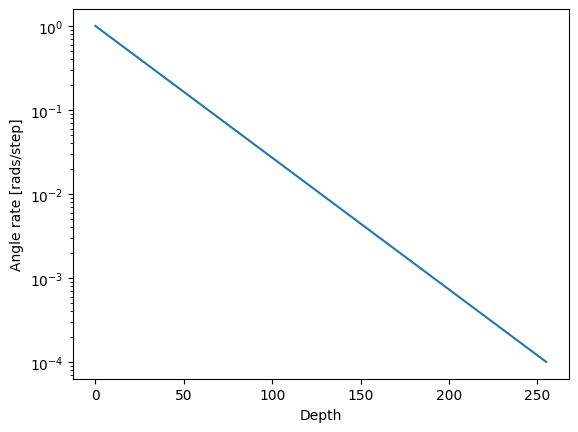

In [11]:
plt.semilogy(angle_rates)
plt.xlabel('Depth')
plt.ylabel('Angle rate [rads/step]')

In [30]:
positions = np.arange(num_positions)
angle_rads = positions[:, np.newaxis] * angle_rates[np.newaxis, :] # The shape is (50, 256)

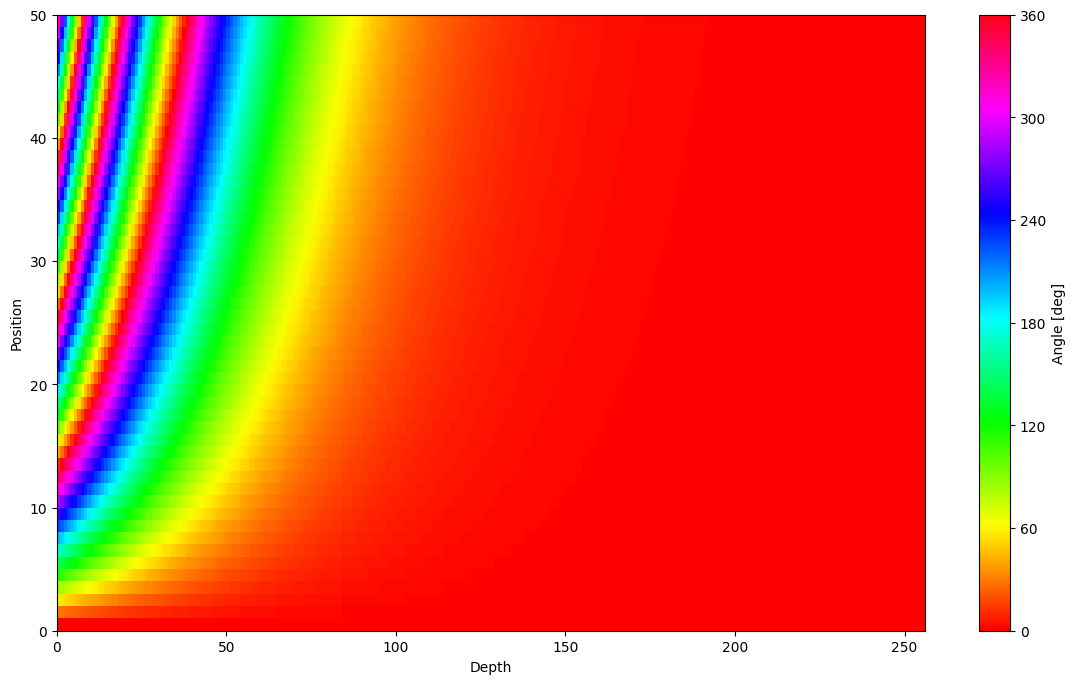

In [31]:
plt.figure(figsize = (14,8))
plt.pcolormesh(
    # Convert to degrees, and wrap around at 360
    angle_rads*180/(2*np.pi) % 360,
    # Use a cyclical colormap so that color(0) == color(360)
    cmap='hsv', vmin=0, vmax=360)

plt.xlim([0,len(angle_rates)])
plt.ylabel('Position')
plt.xlabel('Depth')
bar = plt.colorbar(label='Angle [deg]')
bar.set_ticks(np.linspace(0,360,6+1))

In [32]:
# Raw angles are not a good model input (they're either unbounded, or discontinuous). 
# So take the sine and cosine:
sines = np.sin(angle_rads)
cosines = np.cos(angle_rads)
pos_encoding = np.concatenate([sines, cosines], axis=-1) # (50, 512)


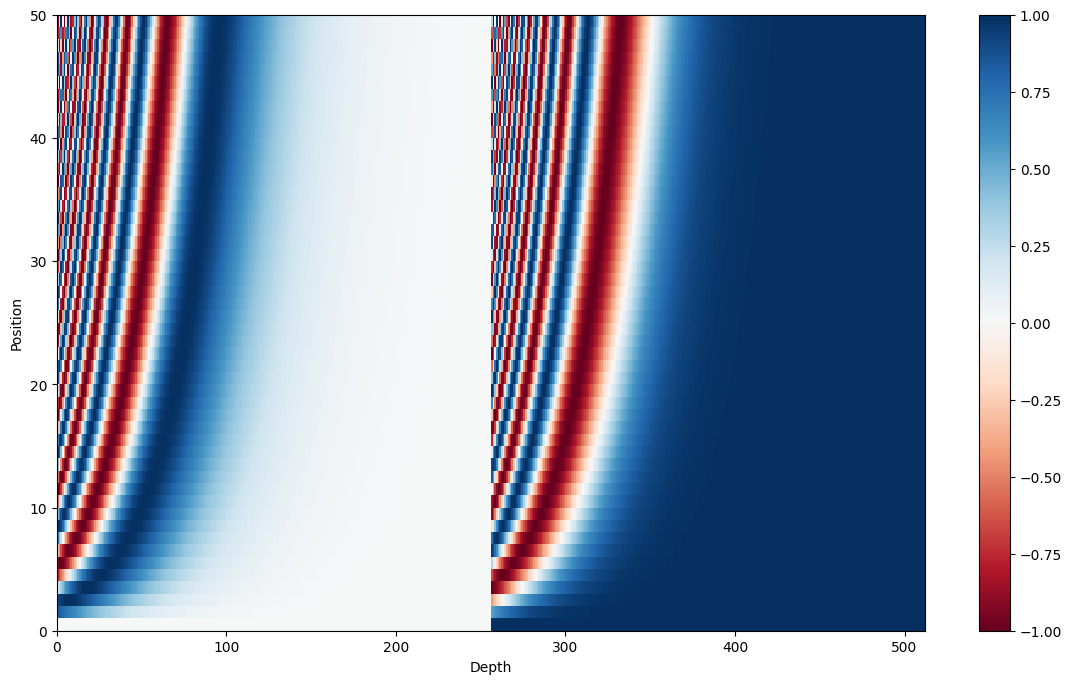

In [33]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding, 
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()

Nearby positions

In [43]:
pos_i = 10
pos_encoding_at_i = pos_encoding[pos_i] # size (512, 1)
dots = np.dot(pos_encoding, pos_encoding_at_i) # (50, 512) (512, 1) => (50, 1)
dots # size ()

array([174.10739434, 179.75169853, 185.24019731, 188.13056069,
       188.51280003, 189.85476914, 196.91675896, 211.91840045,
       231.82560231, 249.12812516, 256.        , 249.12812516,
       231.82560231, 211.91840045, 196.91675896, 189.85476914,
       188.51280003, 188.13056069, 185.24019731, 179.75169853,
       174.10739434, 170.68601269, 169.78442384, 169.68342389,
       168.4011797 , 165.4151489 , 161.89833054, 159.46039211,
       158.6629628 , 158.62691203, 157.95686745, 156.03239401,
       153.48557246, 151.51443696, 150.74771251, 150.71663153,
       150.36091262, 149.0336061 , 147.05902098, 145.36845206,
       144.60624996, 144.55457905, 144.38251942, 143.44318424,
       141.85760383, 140.36122016, 139.59259571, 139.50685866,
       139.4481801 , 138.78361445])

Text(0.5, 0, 'Position')

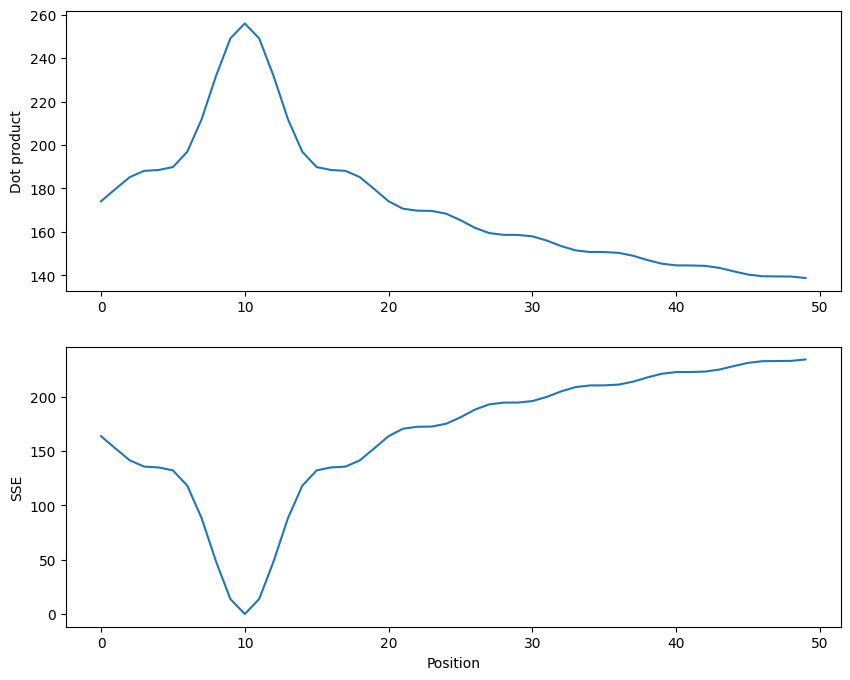

In [44]:
SSE = np.sum((pos_encoding - pos_encoding_at_i)**2, axis=1)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylabel('Dot product')
plt.subplot(2,1,2)
plt.plot(SSE)
plt.ylabel('SSE')
plt.xlabel('Position')

Relative positions

In [39]:
def transition_matrix(position_delta, angle_rates = angle_rates):
  # Implement as a matrix multiply:
  #    sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
  #    cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  
  # b
  angle_delta = position_delta*angle_rates

  # sin(b), cos(b)
  sin_delta = np.sin(angle_delta)
  cos_delta = np.cos(angle_delta)

  I = np.eye(len(angle_rates))
  
  # sin(a+b) = sin(a)*cos(b)+cos(a)*sin(b)
  update_sin = np.concatenate([I*cos_delta, I*sin_delta], axis=0)
  
  # cos(a+b) = cos(a)*cos(b)-sin(a)*sin(b)
  update_cos = np.concatenate([-I*sin_delta, I*cos_delta], axis=0)

  return np.concatenate([update_sin, update_cos], axis=-1)

In [40]:
position_delta = -10
update = transition_matrix(position_delta)

Text(0.5, 0, 'Depth')

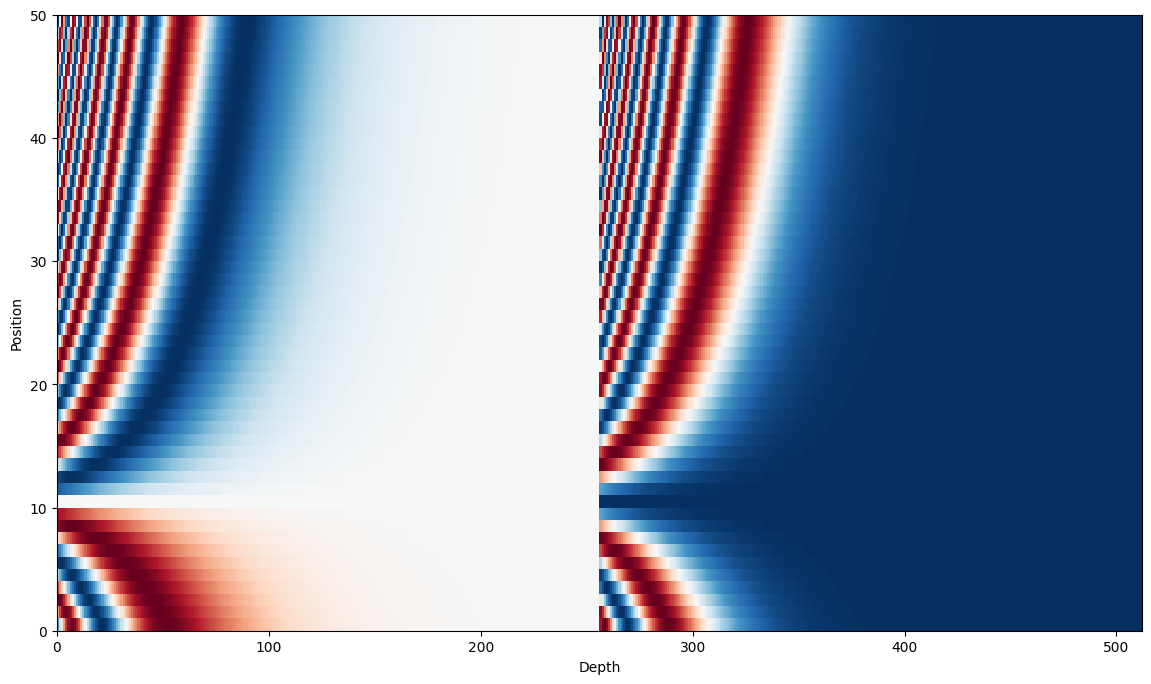

In [41]:
plt.figure(figsize=(14,8))
plt.pcolormesh(np.dot(pos_encoding,update), cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')

In [42]:
errors = np.dot(pos_encoding, update)[10:] - pos_encoding[:-10]
abs(errors).max()

5.4262150328554526e-15